In [1]:
#load packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
# USER INPUT

lensdir='/glade/collections/cdg/data/CLIVAR_LE/cesm_lens/Amon/ts/' # directory where surface temperature data are located
outputdir = '/glade/work/rwills/python_output/forced_component/' # directory for saving Pickle files (copy files and change to a directory you have write access)
name = "cesm_lens" # name used in Pickle files
varnam = 'ts' # set to ts for full ts field, ts50 for 50°S to 50°N 
T = np.arange(1920,2006,1/12) # historical simulations start in 1920 for CESM, 1850 for MPI (first input to arrange must match)
# Second input to arrange can be chosen to select period of interest, but change name used in pickle files for end-dates other than 2006

In [3]:
# Preprocess SST data (or load from Pickle file)

# MPI-LENS fx file for common analsis grid and land mask
ds_fx = xr.open_dataset(outputdir+'T63GR15_jan_surf.nc')
ds_fx = ds_fx.coarsen(lon=2, lat = 2, boundary='trim').mean()
loni = ds_fx.lon
lati = ds_fx.lat
SLF = ds_fx.SLF
mask = SLF.where(SLF<0.5)+1
mask = np.floor(mask.values)
landmask = SLF.where(SLF>0.5)
landmask = np.ceil(landmask.values)
if varnam == 'ts50':
    mask = mask[8:40,:]
    landmask = landmask[8:40,:]

try:
    # load pre-processed SST data from Pickle
    ts_all = pickle.load( open(outputdir+name+"_"+varnam+"_all.p", "rb" ))
    ts_clim_all = pickle.load( open(outputdir+name+"_"+varnam+"_clim_all.p", "rb" ))
    lat = ts_all.lat
    lon = ts_all.lon
    time = ts_all.time
        
except:
    # preprocess SST data and save to Pickle
    
    # get data files
    files = sorted(os.listdir(lensdir))
    files = [s for s in files if "rcp85" in s]
    n = len(files)
    ne = np.empty(n)

    # define axes
    filename0 = lensdir+files[0]
    ds0 = xr.open_dataset(filename0)
    lon = ds0.lon
    lat = ds0.lat
    time = ds0.time
    nt = len(time) 
    nt_cut = len(T)
    month = np.linspace(1, 12, 12)
    
    for ii in range(n):
        # find ensemble member number
        i1 = files[ii].find('85_r')+4
        i2 = files[ii].find('i1')
        ne[ii] = int(files[ii][i1:i2])
    
    ts_all = np.empty((n,nt_cut,len(lat),len(lon)))
    ts_clim_all = np.empty((n,12,len(lat),len(lon)))
    time = time[0:nt_cut]
    ts_all = xr.DataArray(ts_all, coords=[ne, time, lat, lon], dims=["member", "time", "lat", "lon"])
    ts_clim_all = xr.DataArray(ts_clim_all, coords=[ne, month, lat, lon], dims=["member", "month", "lat", "lon"])

    # concatenate all ensemble members into one dataset
    for ii in range(n):
        print(ii)
        filename = lensdir+files[ii]
        ds_member = xr.open_dataset(filename)
        ts = ds_member.ts[-nt:,:,:]
        ts = ts[0:nt_cut,:,:]
        ts_clim = ts.groupby('time.month').mean('time')
        ts_anom = ts.groupby('time.month')-ts_clim
        if ne[ii] >= 35: # workaround because latitude in the CESM runs on a different computer have machine perturbation lat differences
            ts_all[ii,:,:,:] = ts_anom.values
            ts_clim_all[ii,:,:,:] = ts_clim.values
        else:
            ts_all[ii,:,:,:] = ts_anom
            ts_clim_all[ii,:,:,:] = ts_clim
        
    # coarsen resolution by a factor of 2
    ts_all = ts_all.coarsen(lon=2, lat = 2, boundary='trim').mean()
    ts_clim_all = ts_clim_all.coarsen(lon=2, lat = 2, boundary='trim').mean()
    
    # interpolate to common analysis grid (land mask not yet applied)
    if varnam == 'ts50':
        lati = lati[8:40] # to exclude latitudes greater than 50 degrees
    ts_all = ts_all.interp(lon = loni, lat = lati)
    ts_clim_all = ts_clim_all.interp(lon = loni, lat = lati)
    
    pickle.dump(ts_all, open(outputdir+name+"_"+varnam+"_all.p", "wb" ),protocol=4)
    pickle.dump(ts_clim_all, open(outputdir+name+"_"+varnam+"_clim_all.p", "wb" ))
    
ne = ts_all.member
nt = len(ts_all.time)

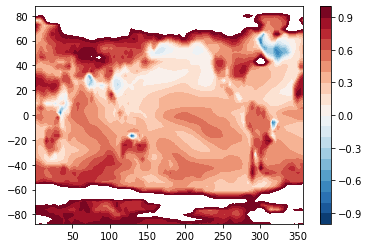

In [4]:
# sanity check plot, just shows changes in temperature over the simulation

field = ts_all.values
field = np.mean(field,axis=0)
field_diff = np.mean(field[912:1031,:,:],axis=0)-np.mean(field[0:119,:,:],axis=0)
f=plt.figure()
plt.contourf(ts_all.lon.values,ts_all.lat.values,field_diff,np.arange(-1,1.1,0.1),cmap=plt.cm.RdBu_r)
cbar = plt.colorbar()

In [5]:
# Preprocessing for Large Ensemble EOFs

lon = ts_all.lon
lat = ts_all.lat
cosw = np.sqrt(np.cos(lat*np.pi/180))
normvec  = cosw/np.sum(cosw);
scale = np.sqrt(normvec);

X=ts_all*scale

X_ensmean=X.mean('member')
X_flat = X.stack(index=['time','member']).stack(shape=['lat','lon'])
X_ensmean_flat = X_ensmean.stack(shape=['lat','lon'])

# keep unscaled copies of these variables
Xt_ensmean=ts_all.mean('member')
Xt_flat = ts_all.stack(index=['time','member']).stack(shape=['lat','lon'])
Xt_ensmean_flat = Xt_ensmean.stack(shape=['lat','lon'])

index = X_flat.index
n = len(index)

In [6]:
%%time
# Perform ensemble EOF analysis (takes a few minutes), or load from Pickle if it has already been done

try:
    # load PCA output from Pickle
    pcvec,evl = pickle.load( open(outputdir+name+"_"+varnam+"_EIG.p", "rb" ))

except:
    # Large Ensemble EOFs
    Cov = np.matmul(X_flat.values.T,X_flat.values)/(n-1)
    evl,pcvec = np.linalg.eig(Cov)
    pickle.dump([pcvec,evl], open(outputdir+name+"_"+varnam+"_EIG.p", "wb" ),protocol=4)
    
s=np.sqrt(evl)

## keeping the below as a reminder that SVD is much slower than eigenvalue analysis for datasets with long time dimension

#%%time
# Perform ensemble EOF analysis (SVD takes ~20-25 minutes), or load from Pickle if it has already been done

#try:
#    # load SVD output from Pickle
#    u,s = pickle.load( open(outputdir+name+"_"+varnam+"_SVD.p", "rb" ))

#except:
    # Large Ensemble EOFs
    
#    #u,s = np.linalg.svd(np.transpose(X_flat.values)/np.sqrt(n-1))
#    u,s = np.linalg.svd(np.transpose(X_flat[0:int(n/10),:].values)/np.sqrt(n/10-1))
#    pickle.dump([u,s], open(outputdir+name+"_"+varnam+"_SVD.p", "wb" ),protocol=4)
    
#eigvals=np.diag(s*s)

CPU times: user 37.5 ms, sys: 93.5 ms, total: 131 ms
Wall time: 324 ms


In [7]:
# S/N Maximizing (Forced) Pattern analysis

neof=200 # number of EOFs retained in S/N maximizing pattern analysis

# Large Ensemble Forced Patterns

S=np.matmul(pcvec[:,0:neof],np.diag(1/s[0:neof]))
Sadj=np.matmul(np.diag(s[0:neof]),pcvec[:,0:neof].T)

ensmeanPCs=np.matmul(X_ensmean_flat.values,S) # ensemble-mean principal components

gamma=np.cov(ensmeanPCs.T)  # covariance matrix of ensemble-mean principal components

u2,signal_frac,v2=np.linalg.svd(gamma)

SNP=np.matmul(v2,Sadj)
SNPs_reshaped=SNP.reshape(neof,len(lat),len(lon))/scale.values[None,:,None]

weights = np.matmul(S,v2.T)
weights = weights.reshape(len(lat),len(lon),neof)*scale.values[:,None,None]

weights=weights.reshape(len(lat)*len(lon),neof)

tk = np.matmul(Xt_flat.values,weights) # compute timeseries from full data matrix
tk_emean = np.matmul(Xt_ensmean_flat.values,weights) # compute ensemble-mean timeseries from ensemble-mean data

sign_eof = np.ones((neof,1))

for ii in range(neof):
    if np.mean(SNP[ii,:]) < 0:
        SNPs_reshaped[ii,:,:] = -SNPs_reshaped[ii,:,:]
        SNP[ii,:] = -SNP[ii,:]
        tk[:,ii] = -tk[:,ii]
        tk_emean[:,ii] = -tk_emean[:,ii]
        sign_eof[ii] = -1
        
pickle.dump([tk,tk_emean,SNPs_reshaped,weights,signal_frac], open(outputdir+name+"_"+varnam+"_SNP"+str(neof)+".p", "wb" ),protocol=4)

[0.90385727 0.67061561 0.53916676 0.36369515 0.31635007 0.2596322
 0.2424868  0.22413783 0.19309309 0.15017554 0.13310729 0.11876491
 0.10575913 0.10198144 0.09447071 0.08300485 0.08274422 0.07544047
 0.07452116 0.07014325 0.06704606 0.06370511 0.0609171  0.0601451
 0.05977246 0.05704092 0.05588487 0.05499472 0.05438227 0.0532423 ]


Text(0.5, 1.0, 'Signal Fraction')

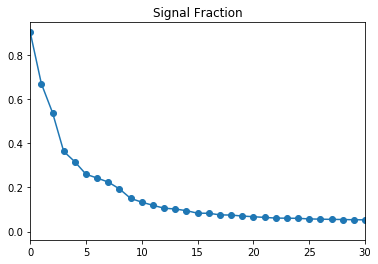

In [8]:
print(signal_frac[0:30])
plt.plot(signal_frac,marker='o')
plt.xlim(0,30)
plt.title('Signal Fraction')

#signal_frac_check = np.zeros(31)
#for ii in range(31): 
#    signal_frac_check[ii] = np.mean(np.square(tk_emean[:,ii]))/np.mean(np.square(tk[:,ii]))
    
#print(signal_frac_check)
#f=plt.figure()
#plt.plot(signal_frac_check,marker='o')
#plt.xlim(0,30)
#plt.title('Signal Fraction Check')

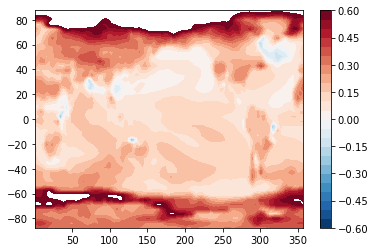

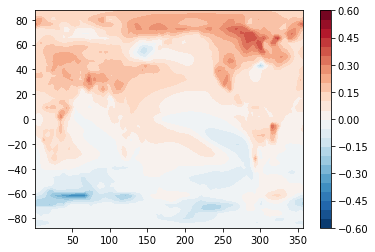

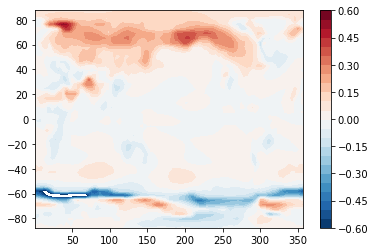

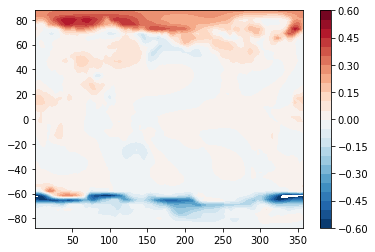

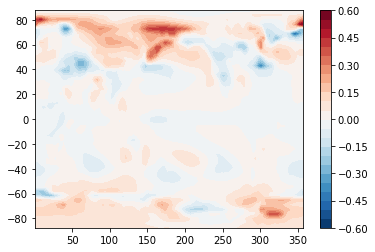

In [9]:
# Plot S/N maximizing patterns (SNPs)
for neof_plot in range(5): 
    f=plt.figure()
    plt.contourf(lon.values,lat.values,np.squeeze(SNPs_reshaped[neof_plot,:,:]),np.arange(-0.6,0.65,0.05),cmap=plt.cm.RdBu_r)
    cbar = plt.colorbar()

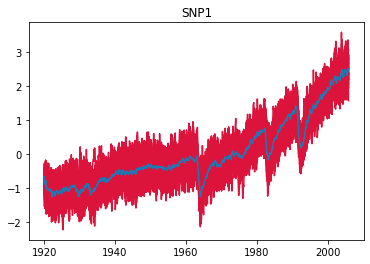

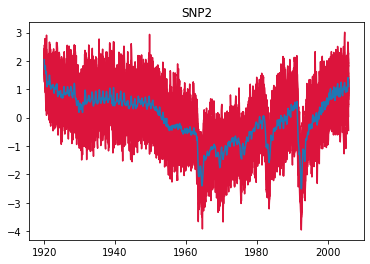

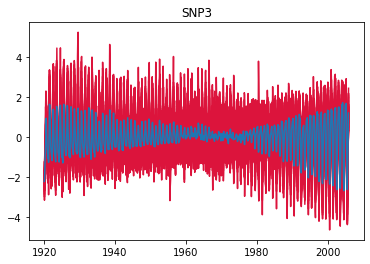

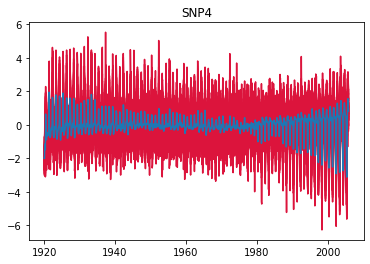

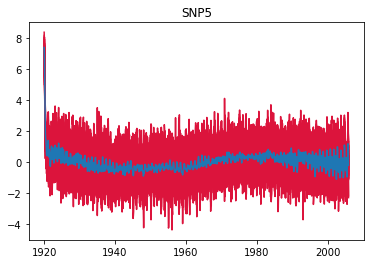

In [10]:
# Plot forced pattern timeseries
tk_reshape=tk.reshape(nt,len(ne),neof)

for neof_plot in range(5): 
    f=plt.figure()
    [plt.plot(T,tk_reshape[:,mm,neof_plot],color='crimson') for mm in range(40)];
    plt.plot(T,tk_emean[:,neof_plot])
    plt.title('SNP'+str(neof_plot+1))

In [11]:
# Forced component from leading forced patterns

M = 13  # number of forced patterns to retain, choose cutoff based on eigenvalue spectrum, or check significant patterns with bootstrapping

X_forced = np.matmul(tk_emean[:,0:M],SNPs_reshaped[0:M,:,:].reshape(M,len(lat)*len(lon)))
X_forced = X_forced.reshape(len(T),len(lat),len(lon))
X_forced_land = X_forced*landmask[None,:,:]
X_forced = xr.DataArray(X_forced, coords=[T,lat,lon], dims=["time","lat","lon"])
X_forced_land = xr.DataArray(X_forced_land, coords=[T,lat,lon], dims=["time","lat","lon"])
Xt_ensmean_land = Xt_ensmean*landmask

GMST_forced = X_forced.mean('lon').mean('lat')
GMST_ensmean = Xt_ensmean.mean('lon').mean('lat')

#Arctic_forced = X_forced.sel(lat=slice(90,65)).mean('lon').mean('lat')
#Arctic_ensmean = Xt_ensmean.sel(lat=slice(90,65)).mean('lon').mean('lat')

tropical_land_forced = X_forced_land.sel(lat=slice(10,-10)).mean('lon').mean('lat')
tropical_land_ensmean = Xt_ensmean_land.sel(lat=slice(10,-10)).mean('lon').mean('lat')

US_land_forced = X_forced_land.sel(lon=slice(235,295),lat=slice(45,30)).mean('lon').mean('lat')
US_land_ensmean = Xt_ensmean_land.sel(lon=slice(235,295),lat=slice(45,30)).mean('lon').mean('lat')

Nino34_forced = X_forced.sel(lon=slice(190,240),lat=slice(5,-5)).mean('lon').mean('lat')
Nino34_ensmean = Xt_ensmean.sel(lon=slice(190,240),lat=slice(5,-5)).mean('lon').mean('lat')

EEP_forced = X_forced.sel(lon=slice(210,270),lat=slice(6,-6)).mean('lon').mean('lat')
EEP_ensmean = Xt_ensmean.sel(lon=slice(210,270),lat=slice(6,-6)).mean('lon').mean('lat')

WEP_forced = X_forced.sel(lon=slice(120,180),lat=slice(6,-6)).mean('lon').mean('lat')
WEP_ensmean = Xt_ensmean.sel(lon=slice(120,180),lat=slice(6,-6)).mean('lon').mean('lat')

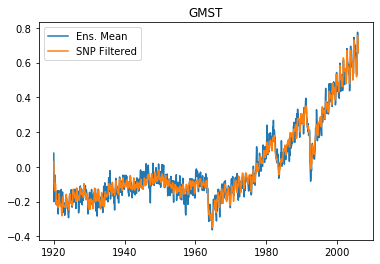

In [12]:
f=plt.figure()
plt.plot(T,GMST_ensmean)
plt.plot(T,GMST_forced)
plt.title('GMST')
plt.legend(('Ens. Mean','SNP Filtered'))

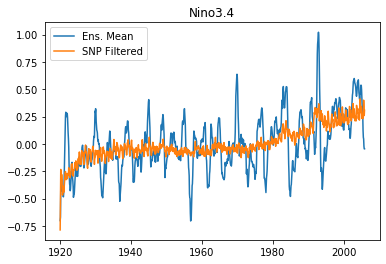

In [13]:
f=plt.figure()
plt.plot(T,Nino34_ensmean)
plt.plot(T,Nino34_forced)
plt.title('Nino3.4')
plt.legend(('Ens. Mean','SNP Filtered'))

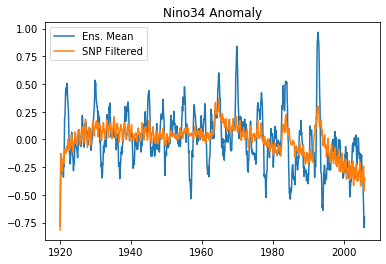

In [14]:
f=plt.figure()
plt.plot(T,Nino34_ensmean-GMST_ensmean)
plt.plot(T,Nino34_forced-GMST_forced)
plt.title('Nino34 Anomaly')
plt.legend(('Ens. Mean','SNP Filtered'))

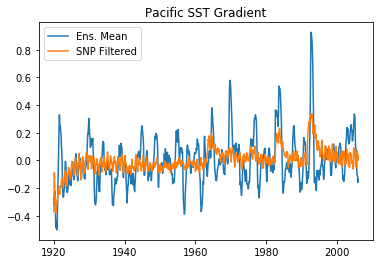

In [15]:
f=plt.figure()
plt.plot(T,EEP_ensmean-WEP_ensmean)
plt.plot(T,EEP_forced-WEP_forced)
plt.title('Pacific SST Gradient')
plt.legend(('Ens. Mean','SNP Filtered'))

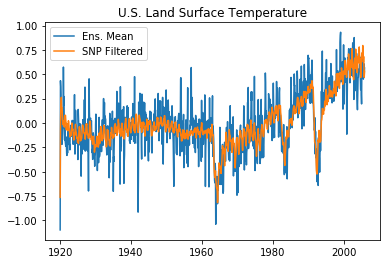

In [16]:
f=plt.figure()
plt.plot(T,US_land_ensmean)
plt.plot(T,US_land_forced)
plt.title('U.S. Land Surface Temperature')
plt.legend(('Ens. Mean','SNP Filtered'))

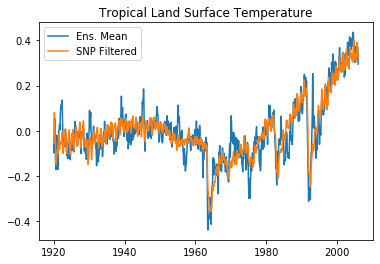

In [17]:
f=plt.figure()
plt.plot(T,tropical_land_ensmean)
plt.plot(T,tropical_land_forced)
plt.title('Tropical Land Surface Temperature')
plt.legend(('Ens. Mean','SNP Filtered'))